Subtask 1: Loading the data

Shape of the images 62 x 47 Pixels
Number of images: 2370
Number of different people: 34

Runtime: 0.02 minutes.


 Subtask2: PCA



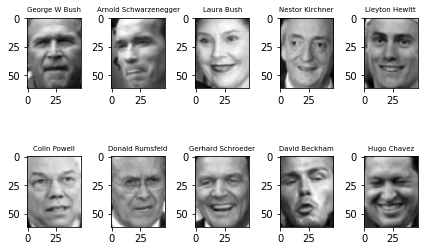

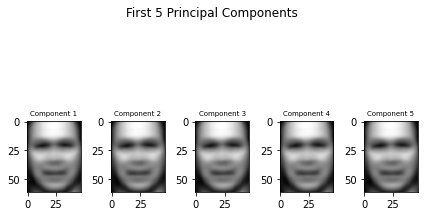

interactive(children=(IntSlider(value=0, description='d'), Output()), _dom_classes=('widget-interact',))

<function __main__.visualize(d)>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.utils.extmath import svd_flip
from sklearn.datasets import fetch_lfw_people
from sklearn.neural_network import MLPRegressor
import datetime
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from IPython.display import display

print("Subtask 1: Loading the data\n")

# Starts the timer
start = datetime.datetime.now()

# loading data set
lfw_people = fetch_lfw_people(min_faces_per_person=30,
                              resize=0.5)

# Important to recostruct images
n_images, height, width = lfw_people.images.shape

# data containing ravelled images
data = lfw_people.data
n_features = data.shape[1]

# Labels of images i.e. the index of the corresp. person
targets = lfw_people.target
target_names = lfw_people.target_names
n_people = target_names.shape[0]
images = lfw_people.images

print(f"Shape of the images {height} x {width} Pixels")
print(f"Number of images: {n_images}")
print(f"Number of different people: {n_people}")

# Plot ten different people
plt.figure()
used_ids = []
i=1
# checks if label has been used already 
# if not plots the images with the corresp. name
for count, index in enumerate(targets, 0):
    if index not in used_ids:
        used_ids.append(index)
        plt.subplot(2,5,i)
        plt.title(target_names[index], fontsize=7)
        plt.imshow(images[count], cmap='gray')
        i+=1
    if i>10:
        break

plt.tight_layout()
plt.savefig('10people.png', dpi=600)
#plt.show()

# split into a stratified training and testing set
xtrain, xtest, ytrain, ytest = train_test_split(
    data, targets, test_size=0.3, random_state=0, stratify=targets)

# Prints the runtime of the given subtask
runtime = (datetime.datetime.now() - start).total_seconds()  
print(f'\nRuntime: {runtime/60:.2f} minutes.\n')

print("\n Subtask2: PCA\n")

class PCA_custom:
    """
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Training data.

    k : int, default=2 
        Number of selected features for analysis of the principal 
        components.
    
    Attributes
    ----------
    Z : array, shape (n_samples, n_components)
        Projected points onto principal components.

    explained_variance_ : array, shape (n_components,)
        The amount of variance explained by each of the selected components.

    explained_variance_ratio_ : array, shape (n_components,)
        Percentage of variance explained by each of the selected components.
    """

    def __init__(self, k=2):
        self.k = k
        
    def fit(self, X):
        
        X = X.copy() # to not overwrite existing X
        n = X.shape[0] # sample size
        
        # Centering the data
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        
        # Compute sigular values and eigenvectors
        u, s, vh = np.linalg.svd(X, full_matrices=False)

        # Select k most important components
        self.evals = s[:self.k].copy()
        self.components_ = vh[:self.k]
    
        #compute percentage of explained variance
        self.explained_variance_ = (s ** 2) / (n - 1)
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(self.explained_variance_)
        self.explained_variance_ratio_ = self.explained_variance_ratio_[:self.k]

        return u, s, vh
    
    def transform(self, X):
        
        X = X - self.mean_
        X_transformed = X @ self.components_.T
        
        return X_transformed
        
    def fit_transform(self, X): 
                
        u, s, vh = self.fit(X) 
        
        # Transforming X
        u = u[:,:self.k]
        u *= s[:self.k]
        
        return u

# Starts the timer
start = datetime.datetime.now()

# Fitting PCA model
pca = PCA_custom(k=5)
xtrain_pca = pca.fit_transform(xtrain)
xtest_pca = pca.transform(xtest)

# Plotting first 5 principal components as images \w mean correction
eigenfaces = (pca.components_+ pca.mean_).reshape((5, height, width)) 

plt.figure()
plt.suptitle("First 5 Principal Components") 
for i in range(1, eigenfaces.shape[0]+1):
    plt.subplot(1,5,i)
    plt.title(f'Component {i}', fontsize=7)
    plt.imshow(eigenfaces[i-1], cmap='gray')
plt.tight_layout()
plt.savefig('firstPCs.png', dpi=600)
#plt.show()

# Plot 10 reconstructed faces for each number of components
ds = [5, 10, 20, 40, 80, 160, 320, 640]

#for d in ds:
def visualize(d): 
    pca = PCA_custom(k=d) 
    xtrain_pca = pca.fit_transform(xtrain)
    xtest_pca = pca.transform(xtest)
    
    # Reconstruct the images after projecting them onto PCs
    reconstructed = (xtrain_pca @ pca.components_) + pca.mean_ 
    
    plt.figure()
    plt.suptitle(f"Using {d} Principal Components") 
    for i in range(1, 11):
        plt.subplot(2,5,i)
        plt.title(target_names[ytrain[i]], fontsize=7)        
        plt.imshow(reconstructed[i].reshape((height, width)), 
                   cmap='gray')
    plt.tight_layout()
    #plt.savefig(f'{d}PCs.png', dpi=600)
    #plt.show()
    """
    # Accuracy scores using Logistic Regression        
    # Data is scaled
    scaler = MinMaxScaler()
    xtrain_pca = scaler.fit_transform(xtrain_pca)
    xtest_pca = scaler.transform(xtest_pca)

    # Logstic Regressor is fitted 
    clf = LogisticRegression(max_iter=1000)
    clf.fit(xtrain_pca, ytrain)
    
    # Accuracy scores
    ytrain_pred = clf.predict(xtrain_pca)
    ytest_pred = clf.predict(xtest_pca)
    score_train = np.mean(ytrain_pred == ytrain)*100
    score_test = np.mean(ytest_pred == ytest)*100

    print(f"\n{score_train:.3f} % / {score_test:.3f} % accuracy score using {d} components (train/test)\n")
    """

interact(visualize, d=IntSlider(min=0, max=100, steps=10))


In [ ]:
# Prints the runtime of the given subtask
runtime = (datetime.datetime.now() - start).total_seconds()  
print(f'\nRuntime: {runtime/60:.2f} minutes.\n')

print('\n Subtask 3: Reduction \w Autoencoders\n')

def encode(X, mlp):
    """  
    Projection.
    X must have the shape n_images x (witdh in pixels * height in pixels)
    """
    
    z = X
    for i in range(len(mlp.coefs_) // 2):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0)
        
    return z

def decode(Z, mlp):
    """    
    Reconstruction.
    Z must have the shape n_images x d
    """
    
    z = Z
    for i in range(len(mlp.coefs_) // 2, len(mlp.coefs_)):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0)
        
    return z

ds = [40, 80]

# Starts the timer
start = datetime.datetime.now()

for d in ds:
    print('\nfitting in progress ...\n')
    
    # Training the regressor model
    regr = MLPRegressor(hidden_layer_sizes=((500, 100, d, 100, 500)),
                        max_iter=500, activation='relu', random_state=0)
    regr.fit(xtrain, xtrain)
    
    # Encoding the images
    xtrain_encoded = encode(xtrain, regr)
    xtest_encoded = encode(xtest, regr)
    
    # Reconstructing the images
    xtrain_decoded = decode(xtrain_encoded, regr)
    
    # Plotting 10 reconstruced images
    plt.figure()
    plt.suptitle(f"Using {d}-dimensional Autoencoder") 
    for i in range(1, 11):
        plt.subplot(2,5,i)
        plt.title(target_names[ytrain[i]], fontsize=7)        
        plt.imshow(xtrain_decoded[i].reshape((height, width)), 
                    cmap=plt.cm.gray)
    plt.tight_layout()
    plt.savefig(f'autoencoder{d}.png', dpi=600)
    #plt.show()
    
    # Scaling data
    scaler = MinMaxScaler().fit(xtrain_encoded)
    xtrain_scaled = scaler.transform(xtrain_encoded)
    xtest_scaled = scaler.transform(xtest_encoded)

    # Training the regressor
    clf = LogisticRegression(max_iter=1000)
    clf.fit(xtrain_scaled, ytrain)

    # Predicting the labels and printing scores
    ytrain_pred = clf.predict(xtrain_scaled)
    ytest_pred = clf.predict(xtest_scaled)
    score_train = np.mean(ytrain_pred == ytrain)*100
    score_test = np.mean(ytest_pred == ytest)*100
    
    print(f"{score_train:.3f} % / {score_test:.3f} % using {d} components (train/test)\n")

# Prints the runtime of the given subtask
runtime = (datetime.datetime.now() - start).total_seconds()  
print(f'\nRuntime: {runtime/60:.2f} minutes.\n')